# 預測元大台灣50開盤價、最高價、最低價、收盤價

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 模型參數設定，小組內律定相關參數以便與其他模型作比較。

In [2]:
epochs = 500 # 律定
batch_size = 100 # 律定
window_size = 10 # 律定
number_of_classes = 4 # 開高收低價四種
learning_rate = 0.001
training_num=3108 # 律定

# 從某資料庫以基本面、技術面、籌碼面等相關專業金融知識挑選近160個相關特徵

In [3]:
taiwan50_stocks = pd.read_csv('all_data_12_1130.csv')

In [4]:
taiwan50_stocks.head()

開盤價    最高價    最低價    收盤價  成交量(張)  成交值(千)    報酬率％     週轉率％  流通在外股數(千股)  \
0  37.09  38.10  37.09  38.05   14290  536078  2.6160  12.3190      116000   
1  38.17  38.82  38.10  38.69   16232  625636  1.6820  13.5267      120000   
2  40.60  40.60  38.81  39.00   16839  661217  0.8012  13.6902      123000   
3  39.10  39.26  38.75  39.26   12491  487753  0.6667  10.3231      121000   
4  39.60  41.00  39.60  41.00   19461  784967  4.4320  17.3759      112000   

   市值(百萬)  ...   標普半年以來漲跌幅 %  標普本年以來漲跌幅 %  sgn     slope       amp  \
0    4413  ...        0.8025      11.6506  1.0  0.003741  0.027238   
1    4642  ...        1.9754      12.9497  1.0  0.003090  0.018922   
2    4797  ...        1.1493      12.0347  1.0  0.068846  0.046265   
3    4750  ...        1.1493      12.0347  1.0  0.002615  0.013077   
4    4592  ...        3.0704      14.1625  1.0  0.006393  0.035660   

      NewDate  year  month  day  week  
0  2003-07-01  2003      7    1     2  
1  2003-07-02  2003      7    1     3  
2  2003-07-03  2003      7    1     4  
3  2003-07-04  2003      7    1     5  
4  2003-07-07  2003      7    1     1  

[5 rows x 162 columns]

In [5]:
taiwan50_stocks.tail()

開盤價   最高價    最低價    收盤價  成交量(張)   成交值(千)    報酬率％    週轉率％  流通在外股數(千股)  \
3680  80.70  80.7  80.45  80.65    5977   481662  0.2486  0.9727      614500   
3681  81.10  81.7  81.05  81.60   17654  1436892  1.1779  2.8729      614500   
3682  82.00  82.6  81.90  82.50   17197  1414607  1.1029  2.7985      614500   
3683  82.35  82.4  81.65  81.65    7222   592065 -1.0303  1.1987      602500   
3684  81.45  81.8  81.40  81.75    8293   677320  0.1225  1.3764      602500   

      市值(百萬)  ...   標普半年以來漲跌幅 %  標普本年以來漲跌幅 %  sgn     slope       amp  \
3680   49559  ...        1.8500       1.8500  1.0  0.007812  0.003108   
3681   50143  ...        2.0240       2.0240  1.0  0.004483  0.008060   
3682   50696  ...        2.1142       2.1142  1.0  0.002941  0.008578   
3683   49194  ...        1.4155       1.4155 -1.0 -0.002820 -0.009091   
3684   49254  ...        1.8274       1.8274 -1.0 -0.001843 -0.004899   

         NewDate  year  month  day  week  
3680  2018-05-10  2018      5    1     4  
3681  2018-05-11  2018      5    2     5  
3682  2018-05-14  2018      5    2     1  
3683  2018-05-15  2018      5    2     2  
3684  2018-05-16  2018      5    2     3  

[5 rows x 162 columns]

# 檢查資料庫中的最高價是否真的為最高價，反之亦然。

In [6]:
not_max=0
not_min=0
for i in range(len(taiwan50_stocks['開盤價'])):
    check_temp=np.sort([taiwan50_stocks['開盤價'][i],taiwan50_stocks['最高價'][i],taiwan50_stocks['最低價'][i],taiwan50_stocks['收盤價'][i]])
    if check_temp[0]!=taiwan50_stocks['最低價'][i]:
        not_min+=1
    if check_temp[-1]!=taiwan50_stocks['最高價'][i]:
        not_max+=1
print('There are {} minimum that is not the real minimun.'.format(not_max))
print('There are {} maximum that is not the real maximun.'.format(not_min))

There are 0 minimum that is not the real minimun.
There are 0 maximum that is not the real maximun.


# 經過幾次訓練後決定捨棄某些特徵

In [7]:
data_to_use = taiwan50_stocks.drop(['NewDate','sgn','slope','amp','idxmax-idxmin'], axis=1).values

In [8]:
print('Total number of features in the dataset: {}'.format(data_to_use.shape[1]))
print('Total number of days in the dataset: {}'.format(data_to_use.shape[0]))

Total number of features in the dataset: 157
Total number of days in the dataset: 3685


# 由於開盤價、收盤價、最高價與最低價有特定的相對關係，故需要以相同的基準作標準化。

In [9]:
price=data_to_use[:,:4]
price_mean = np.mean(price)
price_std  = np.std(price)
scaled_dataset_price=(price-price_mean)/price_std
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(data_to_use)
scaled_dataset[:,:4]=scaled_dataset_price

# 檢查資料庫中的最高價是否真的為最高價，反之亦然。

In [10]:
not_max=0
not_min=0
for i in range(len(scaled_dataset[:,0])):
    check_temp=np.sort([scaled_dataset[i,0],scaled_dataset[i,1],scaled_dataset[i,2],scaled_dataset[i,3]])
    if check_temp[0]!=scaled_dataset[i,2]:
        not_min+=1
    if check_temp[-1]!=scaled_dataset[i,1]:
        not_max+=1
print('There are {} minimum that is not the real minimun'.format(not_max))
print('There are {} maximum that is not the real maximun'.format(not_min))

There are 0 minimum that is not the real minimun
There are 0 maximum that is not the real maximun


# 從2003年七月到2018年五月台灣50開盤價、最高價、最低價、收盤價每日變化圖

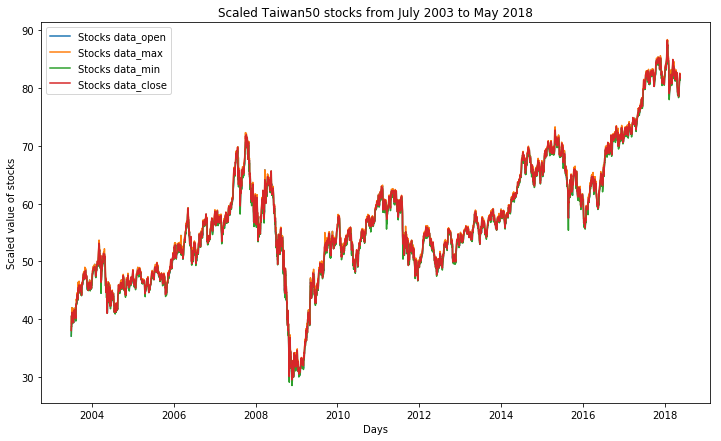

In [11]:
taiwan50_stocks.NewDate = pd.to_datetime(taiwan50_stocks.NewDate)
plt.figure(figsize=(12,7)).patch.set_facecolor('white')
plt.title('Scaled Taiwan50 stocks from July 2003 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(taiwan50_stocks.NewDate, data_to_use[:,0], label='Stocks data_open')
plt.plot(taiwan50_stocks.NewDate, data_to_use[:,1], label='Stocks data_max')
plt.plot(taiwan50_stocks.NewDate, data_to_use[:,2], label='Stocks data_min')
plt.plot(taiwan50_stocks.NewDate, data_to_use[:,3], label='Stocks data_close')
plt.legend()
plt.show()

# 模型訓練、測試數據整理

In [12]:
def window_data(INPUT, OUTPUT, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(INPUT) - 1:
        X.append(INPUT[i:i+window_size,:])
        y.append(OUTPUT[i+window_size,:])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [13]:
X, y = window_data(scaled_dataset,scaled_dataset[:,0:4], window_size)

In [14]:
X_train  = np.array(X[:training_num])
y_train = np.array(y[:training_num])

X_test = np.array(X[training_num:])
y_test = np.array(y[training_num:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (3108, 10, 157)
y_train size: (3108, 4)
X_test size: (567, 10, 157)
y_test size: (567, 4)


# 建立CNN1D模型

In [15]:
def output_layer(conv1d_output, out_size):
    
    ## global average pooling 1D
    x = tf.reduce_mean(conv1d_output, axis=[1])
    output = tf.layers.dense(inputs= x, units= out_size)
    return output

In [16]:
def opt_loss(logits, targets, learning_rate):
    
    loss = tf.reduce_sum(tf.pow(logits - targets, 2))/batch_size 
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.minimize(loss)
    
    return loss, train_optimizer

In [17]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    ##defining placeholders##
    with tf.name_scope('input'):
        inputs = tf.placeholder(tf.float32, [None, window_size, data_to_use.shape[1]], name='input_data')
        targets = tf.placeholder(tf.float32, [None, number_of_classes], name='targets')
        
    ##convolution layer##
    with tf.variable_scope("conv_layer1"):
        conv_layer1 = tf.layers.conv1d(inputs, 32, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale=1e-5))
    with tf.variable_scope("conv_layer2"):
        conv_layer2 = tf.layers.conv1d(conv_layer1, 64, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale=1e-5))
    with tf.variable_scope("conv_layer3"):
        conv_layer3 = tf.layers.conv1d(conv_layer2, 128, kernel_size=3, strides=1, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale=1e-5))

    ##Output layer##   
    with tf.variable_scope('output_layer'):
        logits = output_layer(conv_layer3, number_of_classes)
    ##loss and optimization##
    with tf.name_scope('loss_and_opt'):
        loss, opt = opt_loss(logits, targets, learning_rate)
    
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    

# 模型訓練

In [18]:
# sess.run(init)
# for i in range(epochs):
#     traind_scores = []
#     ii = 0
#     epoch_loss = []
#     while(ii + batch_size) <= len(X_train):
#         X_batch = X_train[ii:ii+batch_size]
#         y_batch = y_train[ii:ii+batch_size].reshape((batch_size,number_of_classes))
        
#         o, c, _ = sess.run([logits, loss, opt], feed_dict={inputs:X_batch, targets:y_batch})
        
#         epoch_loss.append(c)
#         traind_scores.append(o)
#         ii += batch_size
#     if (i % 50) == 0:
#         print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
# print('Done!')
# saver.save(sess, './model/model.ckpt', global_step=1) # 儲存模型「model.ckpt」至「model」資料夾

# 載入已訓練好之模型

In [19]:
#load model
ckpt_path = './model_1205-1/model.ckpt'
saver.restore(sess, ckpt_path + '-'+ str(1))

INFO:tensorflow:Restoring parameters from ./model_1205-1/model.ckpt-1


# 獲得模型預測結果

In [20]:
#Training set預測結果
training_set_pred = []
for i in range(len(X_train)):
    training_set_pred.append(sess.run(logits, feed_dict={inputs:X_train[i:i+1]}))
training_set_pred=np.array(training_set_pred)

In [21]:
#Testing set預測結果
testing_set_pred = []
for i in range(len(X_test)):
    testing_set_pred.append(sess.run(logits, feed_dict={inputs:X_test[i:i+1]}))
testing_set_pred=np.array(testing_set_pred)

In [22]:
sess.close()

# 模型預測結果評估

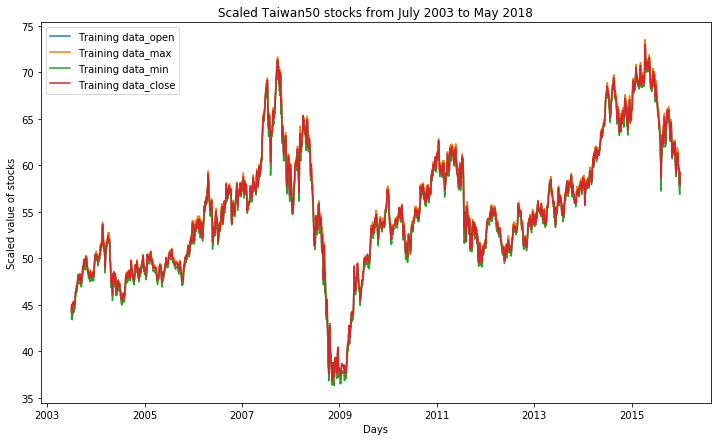

In [23]:
scale_factor=0
plt.figure(figsize=(12,7)).patch.set_facecolor('white')
plt.title('Scaled Taiwan50 stocks from July 2003 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(taiwan50_stocks.NewDate[scale_factor:training_num], training_set_pred[scale_factor:,0,0]*price_std+price_mean, label='Training data_open')
plt.plot(taiwan50_stocks.NewDate[scale_factor:training_num], training_set_pred[scale_factor:,0,1]*price_std+price_mean, label='Training data_max')
plt.plot(taiwan50_stocks.NewDate[scale_factor:training_num], training_set_pred[scale_factor:,0,2]*price_std+price_mean, label='Training data_min')
plt.plot(taiwan50_stocks.NewDate[scale_factor:training_num], training_set_pred[scale_factor:,0,3]*price_std+price_mean, label='Training data_close')
plt.legend()
plt.show()

# 檢查訓練預測中的最高價是否真的為最高價，反之亦然。

In [24]:
max_not_max_training=0
min_not_min_training=0
for i in range(len(training_set_pred[:,0,0])):
    stock = np.sort([training_set_pred[i,0,0],training_set_pred[i,0,1],training_set_pred[i,0,2],training_set_pred[i,0,3]])
    if stock[0] != training_set_pred[i,0,2]:
        min_not_min_training+=1
    if stock[-1] != training_set_pred[i,0,1]:
        max_not_max_training+=1
print('There are {} predictions of traning'.format(len(training_set_pred[:,0,0])))
print('There are {} minimum predictions of traning that is not the real minimun'.format(min_not_min_training))
print('There are {} maximum predictions of traning that is not the real maximun'.format(max_not_max_training))

There are 3108 predictions of traning
There are 73 minimum predictions of traning that is not the real minimun
There are 228 maximum predictions of traning that is not the real maximun


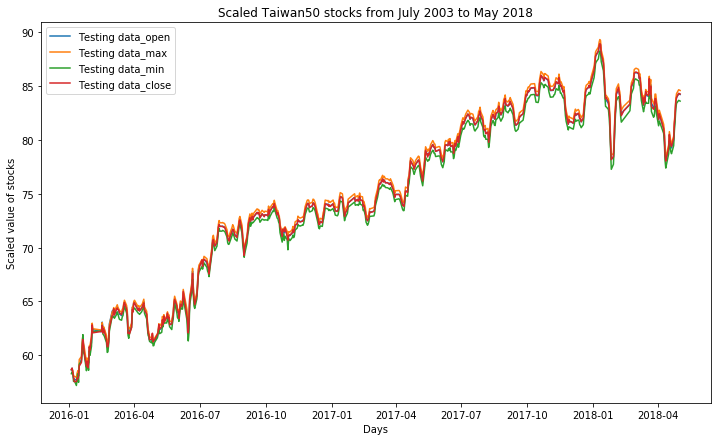

In [25]:
scale_factor=0
plt.figure(figsize=(12,7)).patch.set_facecolor('white')
plt.title('Scaled Taiwan50 stocks from July 2003 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(taiwan50_stocks.NewDate[training_num+scale_factor:-window_size], testing_set_pred[scale_factor:,0,0]*price_std+price_mean, label='Testing data_open')
plt.plot(taiwan50_stocks.NewDate[training_num+scale_factor:-window_size], testing_set_pred[scale_factor:,0,1]*price_std+price_mean, label='Testing data_max')
plt.plot(taiwan50_stocks.NewDate[training_num+scale_factor:-window_size], testing_set_pred[scale_factor:,0,2]*price_std+price_mean, label='Testing data_min')
plt.plot(taiwan50_stocks.NewDate[training_num+scale_factor:-window_size], testing_set_pred[scale_factor:,0,3]*price_std+price_mean, label='Testing data_close')
plt.legend()
plt.show()

# 檢查測試預測中的最高價是否真的為最高價，反之亦然。

In [26]:
max_not_max_testing=0
min_not_min_testing=0
for i in range(len(testing_set_pred[:,0,0])):
    stock = np.sort([testing_set_pred[i,0,0],testing_set_pred[i,0,1],testing_set_pred[i,0,2],testing_set_pred[i,0,3]])
    if stock[0] != testing_set_pred[i,0,2]:
        min_not_min_testing+=1
    if stock[-1] != testing_set_pred[i,0,1]:
        max_not_max_testing+=1
print('There are {} predictions of testing'.format(len(testing_set_pred[:,0,0])))
print('There are {} minimum predictions of testing that is not the real minimun'.format(min_not_min_testing))
print('There are {} maximum predictions of testing that is not the real maximun'.format(max_not_max_testing))

There are 567 predictions of testing
There are 13 minimum predictions of testing that is not the real minimun
There are 14 maximum predictions of testing that is not the real maximun


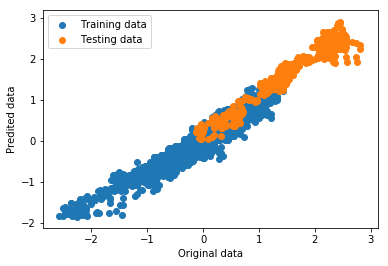

In [27]:
plt.figure().patch.set_facecolor('white')
plt.scatter(scaled_dataset[:training_num,0], training_set_pred[:,0,0], label='Training data')
plt.scatter(scaled_dataset[training_num:-window_size,0], testing_set_pred[:,0,0], label='Testing data')
plt.legend()
plt.xlabel('Original data')
plt.ylabel('Predited data')
plt.show()

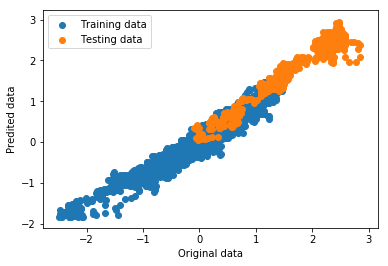

In [28]:
plt.figure().patch.set_facecolor('white')
plt.scatter(scaled_dataset[:training_num,1], training_set_pred[:,0,1], label='Training data')
plt.scatter(scaled_dataset[training_num:-window_size,1], testing_set_pred[:,0,1], label='Testing data')
plt.legend()
plt.xlabel('Original data')
plt.ylabel('Predited data')
plt.show()

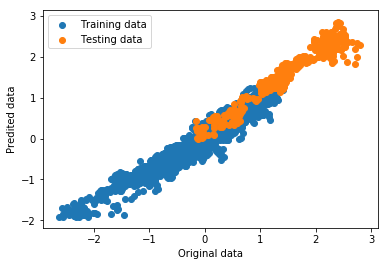

In [29]:
plt.figure().patch.set_facecolor('white')
plt.scatter(scaled_dataset[:training_num,2], training_set_pred[:,0,2], label='Training data')
plt.scatter(scaled_dataset[training_num:-window_size,2], testing_set_pred[:,0,2], label='Testing data')
plt.legend()
plt.xlabel('Original data')
plt.ylabel('Predited data')
plt.show()

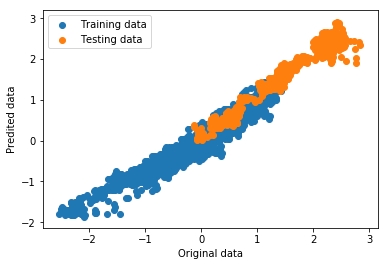

In [30]:
plt.figure().patch.set_facecolor('white')
plt.scatter(scaled_dataset[:training_num,3], training_set_pred[:,0,3], label='Training data')
plt.scatter(scaled_dataset[training_num:-window_size,3], testing_set_pred[:,0,3], label='Testing data')
plt.legend()
plt.xlabel('Original data')
plt.ylabel('Predited data')
plt.show()

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt
def predicted_eva(y_predicted,val_data):
#     y_predicted = model.predict(pre_data)
    mae = metrics.mean_absolute_error(y_predicted, val_data)
    mse = metrics.mean_squared_error(y_predicted, val_data)
    r2 = metrics.r2_score(y_predicted, val_data)
    plt.figure().patch.set_facecolor('white')
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.plot(y_predicted, val_data,'.')
    plt.title('Plot for ' + 'mae:%.2f'%mae
                     + '\n' + 'mse:%.2f'%mse
                     + '\n' + 'r2:%.2f'%r2)
    plt.show()

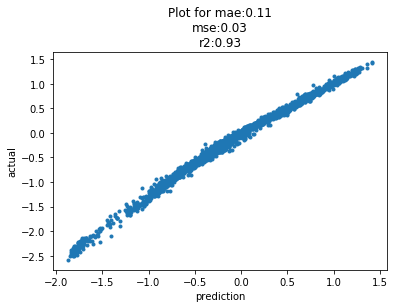

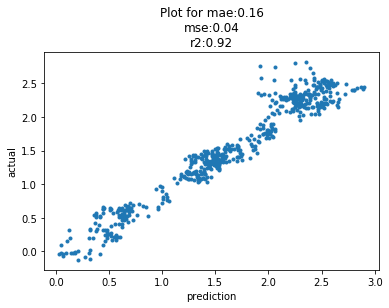

In [32]:
predicted_eva(np.array(training_set_pred[:,0,0]), np.array(scaled_dataset[window_size:training_num+window_size,0]))
predicted_eva(np.array(testing_set_pred[:,0,0]), np.array(scaled_dataset[training_num:-window_size,0]))

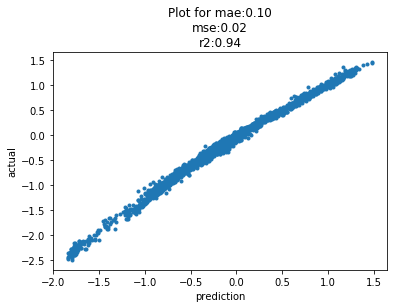

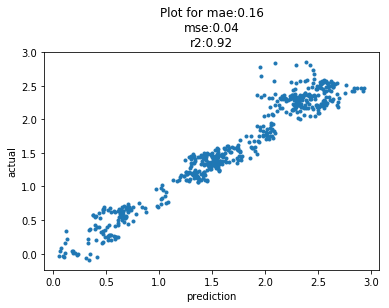

In [33]:
predicted_eva(np.array(training_set_pred[:,0,1]), np.array(scaled_dataset[window_size:training_num+window_size,1]))
predicted_eva(np.array(testing_set_pred[:,0,1]), np.array(scaled_dataset[training_num:-window_size,1]))

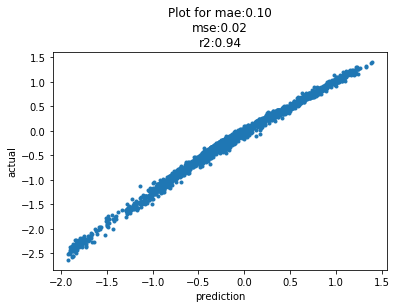

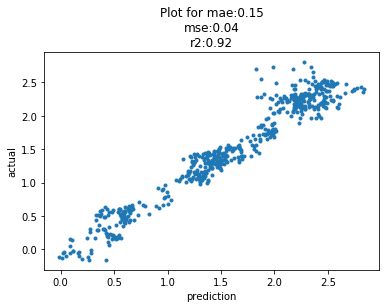

In [34]:
predicted_eva(np.array(training_set_pred[:,0,2]), np.array(scaled_dataset[window_size:training_num+window_size,2]))
predicted_eva(np.array(testing_set_pred[:,0,2]), np.array(scaled_dataset[training_num:-window_size,2]))

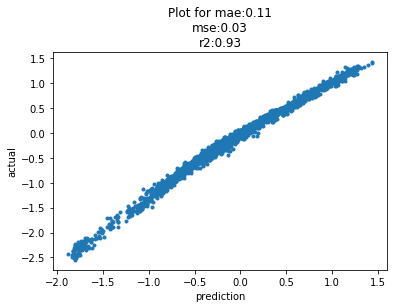

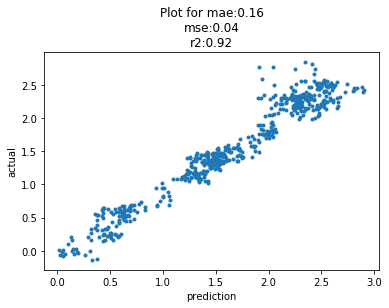

In [35]:
predicted_eva(np.array(training_set_pred[:,0,3]), np.array(scaled_dataset[window_size:training_num+window_size,3]))
predicted_eva(np.array(testing_set_pred[:,0,3]), np.array(scaled_dataset[training_num:-window_size,3]))

# 程式結束